In [1]:
import os
import pandas as pd
#import Bio.PDB.PDBList as biopy
#import PCN
import traceback
import tarfile
import random
import numpy as np
import networkx as nx
import random
import Bio
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import MDAnalysis as mda
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,matthews_corrcoef,roc_curve, auc
torch.set_grad_enabled(False)
import urllib,ast

In [3]:
!conda install --yes MDAnalysis MDAnalysisTests

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/rohan/opt/anaconda3/envs/dl

  added / updated specs:
    - mdanalysis
    - mdanalysistests


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.79             |   py38hed1de0f_2         2.6 MB  conda-forge
    ca-certificates-2022.6.15  |       h033912b_0         149 KB  conda-forge
    certifi-2022.6.15          |   py38h50d1736_0 

In [4]:
file=open("/Users/rohan/Desktop/DTI_setup/data/davis/proteins_updated.txt","r")
contents=file.read()
protein_data=ast.literal_eval(contents)
protein_data.keys()

dict_keys(['AAK1', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B', 'ACVRL1', 'ADCK3', 'ADCK4', 'AKT1', 'AKT2', 'AKT3', 'AMPK-alpha1', 'AMPK-alpha2', 'ANKK1', 'ARK5', 'AURKA', 'AURKB', 'AURKC', 'AXL', 'BLK', 'BMPR1A', 'BMPR1B', 'BMX', 'BRAF', 'BRAF(V600E)', 'BRK', 'BRSK1', 'BRSK2', 'BTK', 'CAMK1', 'CAMK1D', 'CAMK1G', 'CAMK2A', 'CAMK2B', 'CAMK2D', 'CAMK2G', 'CAMK4', 'CAMKK1', 'CAMKK2', 'CASK', 'CDC2L1', 'CDC2L2', 'CDC2L5', 'CDK11', 'CDK2', 'CDK3', 'CDK4-cyclinD1', 'CDK4-cyclinD3', 'CDK5', 'CDK7', 'CDK8', 'CDK9', 'CDKL1', 'CDKL2', 'CDKL3', 'CHEK1', 'CHEK2', 'CLK1', 'CLK2', 'CLK3', 'CLK4', 'CSF1R', 'CSK', 'CSNK1A1', 'CSNK1A1L', 'CSNK1D', 'CSNK1E', 'CSNK1G1', 'CSNK1G2', 'CSNK1G3', 'CSNK2A1', 'CSNK2A2', 'CTK', 'DAPK2', 'DAPK3', 'DCAMKL1', 'DCAMKL2', 'DCAMKL3', 'DDR1', 'DDR2', 'DLK', 'DMPK', 'DRAK1', 'DRAK2', 'DYRK1A', 'DYRK1B', 'DYRK2', 'EIF2AK1', 'EPHA1', 'EPHA2', 'EPHA3', 'EPHA4', 'EPHA5', 'EPHA6', 'EPHA7', 'EPHA8', 'EPHB1', 'EPHB2', 'EPHB3', 'EPHB4', 'EPHB6', 'ERK1', 'ERK2', 'ERK3', 'ERK4', 'ERK5'

In [5]:
list_prots=list(protein_data.keys())
len(list_prots)

333

In [2]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

def load_ESM_1b():
    """ Download the ESM_1b model and initalizes it."""
    esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    esm1b = esm1b.eval().cpu()
    #esm1b = esm1b.eval().cuda() #for gpu machines with CUDA
    esm1b_batch_converter = esm1b_alphabet.get_batch_converter()
    return esm1b,esm1b_batch_converter

In [3]:
def getContactMap_fromESM(esm1b,esm1b_batch_converter,seq_data):
    """ Loads the ESM_1b model, computes contact map from the input sequence data """
    esm1b_data = [seq_data]
    esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
    esm1b_batch_tokens = esm1b_batch_tokens.cpu()
    esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
    seqlen = len(esm1b_batch_strs[0])
    contact_map=esm1b_contacts[0][:seqlen, :seqlen]>=0.1
    contact_map=contact_map.numpy()
    contact_map=np.multiply(contact_map,1)
    return contact_map

In [2]:
def getContactMap_fromPDB(PDB_file):
    """ Takes a PDB file and creates a PCN from the alpha carbons and computes distance matrix 
    followed by generating a contact map with 8.0 Å threshold value."""
    protein_contact_network = PCN.PCN(PDB_file)
    C_alphas = protein_contact_network.get_C_alphas()
    chain_length = protein_contact_network.get_chain_length(C_alphas)
    if protein_contact_network.get_link_lengths(C_alphas) is not None:
        distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
        plt.imshow(distance_matrix)
        #print(np.unique(distance_matrix))
        contact_map = distance_matrix >=8
        #print(np.unique(contact_map))
        contact_map=np.multiply(contact_map,1)
        #print(contact_map)
        return contact_map
    else:
        return None

In [3]:
def main():
    PDB_IDs = list_prots
    #PDB_IDs = ['P80192']
    results_path="/Users/rohan/Desktop/DTI_setup/data/davis/alpha_fold_cmaps1/" 
    for i,j in enumerate(PDB_IDs):
        print(PDB_IDs[i])
        PDB_IDs_lower = str(PDB_IDs[i])
        #Set path to PDB files
        PDB_file = f'//Users/rohan/Desktop/DTI_setup/data/davis/alphafold2_structures/{PDB_IDs_lower}.pdb' 
        if os.path.isfile(PDB_file):
            contact_pdb=getContactMap_fromPDB(PDB_file)
            contact_pdb=np.asarray(contact_pdb)
            #plt.imshow(contact_pdb)
            print(contact_pdb.shape)
            savepath='/Users/rohan/Desktop/DTI_setup/data/davis/alpha_fold_cmaps1/'+PDB_IDs_lower+'.npy'
            np.save(savepath,contact_pdb)


In [4]:
main()

NameError: name 'list_prots' is not defined

In [ ]:
def main():
    PDB_IDs = list(davis_p.keys())
    #Load ESM_1b Model
    esm1b,esm1b_batch_converter=load_ESM_1b()
    #Set the path to results
    results_path="/disk/scratch/Protein_ContactMaps_DL_BindingAffinity/DGraphDTA/data/davis/esm_contact_results/" 
    for i,j in enumerate(PDB_IDs):
        print(PDB_IDs[i])
        PDB_IDs_lower = str(PDB_IDs[i]).lower()
        #Set path to PDB files
        PDB_file = f'//Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb{PDB_IDs_lower}.ent' 
        #Set path to FASTA files
        fasta_file=f'//Users/rohan/Desktop/DTI_setup/data_main/fasta_files/{PDB_IDs[i]}_1.fasta'
        if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
            contact_pdb=getContactMap_fromPDB(PDB_file)
            contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file)
            if contact_pdb is not None:
                compareContactMaps(contact_pdb,contact_esm,PDB_IDs[i],results_path)
            else: 
                continue

In [14]:
 list(davis_p.keys())

['AAK1',
 'ABL1(E255K)',
 'ABL1(F317I)',
 'ABL1(F317I)p',
 'ABL1(F317L)',
 'ABL1(F317L)p',
 'ABL1(H396P)',
 'ABL1(H396P)p',
 'ABL1(M351T)',
 'ABL1(Q252H)',
 'ABL1(Q252H)p',
 'ABL1(T315I)',
 'ABL1(T315I)p',
 'ABL1(Y253F)',
 'ABL1',
 'ABL1p',
 'ABL2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVR2B',
 'ACVRL1',
 'ADCK3',
 'ADCK4',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'AMPK-alpha1',
 'AMPK-alpha2',
 'ANKK1',
 'ARK5',
 'ASK1',
 'ASK2',
 'AURKA',
 'AURKB',
 'AURKC',
 'AXL',
 'BIKE',
 'BLK',
 'BMPR1A',
 'BMPR1B',
 'BMPR2',
 'BMX',
 'BRAF',
 'BRAF(V600E)',
 'BRK',
 'BRSK1',
 'BRSK2',
 'BTK',
 'CAMK1',
 'CAMK1D',
 'CAMK1G',
 'CAMK2A',
 'CAMK2B',
 'CAMK2D',
 'CAMK2G',
 'CAMK4',
 'CAMKK1',
 'CAMKK2',
 'CASK',
 'CDC2L1',
 'CDC2L2',
 'CDC2L5',
 'CDK11',
 'CDK2',
 'CDK3',
 'CDK4-cyclinD1',
 'CDK4-cyclinD3',
 'CDK5',
 'CDK7',
 'CDK8',
 'CDK9',
 'CDKL1',
 'CDKL2',
 'CDKL3',
 'CDKL5',
 'CHEK1',
 'CHEK2',
 'CIT',
 'CLK1',
 'CLK2',
 'CLK3',
 'CLK4',
 'CSF1R',
 'CSK',
 'CSNK1A1',
 'CSNK1A1L',
 'CSNK1D',
 'CSNK1E

In [17]:
data = [
    ("AKT1", "MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVDQREAPLNNFSVAQCQLMKTERPRPNTFIIRCLQWTTVIERTFHVETPEEREEWTTAIQTVADGLKKQEEEEMDFRSGSPSDNSGAEEMEVSLAKPKHRVTMNEFEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHTLTENRVLQNSRHPFLTALKYSFQTHDRLCFVMEYANGGELFFHLSRERVFSEDRARFYGAEIVSALDYLHSEKNVVYRDLKLENLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEEIRFPRTLGPEAKSLLSGLLKKDPKQRLGGGSEDAKEIMQHRFFAGIVWQHVYEKKLSPPFKPQVTSETDTRYFDEEFTAQMITITPPDQDDSMECVDSERRPHFPQFSYSASGTA"),
]

In [18]:
esm1b,esm1b_batch_converter=load_ESM_1b()
esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(data)
esm1b_batch_tokens = esm1b_batch_tokens.cpu()
print(esm1b_batch_tokens.size(), esm1b_batch_tokens.dtype)
esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()

torch.Size([1, 482]) torch.int64


In [19]:
esm1b_contacts 

tensor([[[0.8544, 0.0942, 0.3474,  ..., 0.0101, 0.0098, 0.0119],
         [0.0942, 0.0589, 0.4746,  ..., 0.0075, 0.0072, 0.0073],
         [0.3474, 0.4746, 0.8358,  ..., 0.0068, 0.0068, 0.0070],
         ...,
         [0.0101, 0.0075, 0.0068,  ..., 0.0166, 0.0143, 0.1438],
         [0.0098, 0.0072, 0.0068,  ..., 0.0143, 0.0034, 0.0050],
         [0.0119, 0.0073, 0.0070,  ..., 0.1438, 0.0050, 0.0074]]])

In [20]:
type(data)

list

In [21]:
type(davis_p)

dict

In [27]:
davis= list(davis_p.items())
print(davis)

[('AAK1', 'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL'), ('ABL1(E255K)', 'PFWKILN

In [48]:
davis[0]

('AAK1',
 'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL')

In [66]:
pwd

'/Users/rohan/Desktop/DTI_setup'

In [73]:
def save_esm_cmaps(protein_data):
    seq_data= list(protein_data.items())
    PDB_IDs = list(protein_data.keys())
    #Load ESM_1b Model
    esm1b,esm1b_batch_converter=load_ESM_1b()
    #Set the path to results
    results_path="/Users/rohan/Desktop/DTI_setup/data/davis/esm_contact_results/" 
    for i,j in enumerate(PDB_IDs):
        print(len(seq_data[i][1]))
        if len(seq_data[i][1])<=1024:
            print(PDB_IDs[i])
            contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,seq_data[i])
            filename=results_path+PDB_IDs[i]
            np.save(filename,contact_esm)
        else:
            continue

In [74]:
save_esm_cmaps(protein_data)

961
AAK1
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
1167
509
ACVR1
505
ACVR1B
513
ACVR2A
512
ACVR2B
503
ACVRL1
647
ADCK3
544
ADCK4
480
AKT1
481
AKT2
479
AKT3
1620
559
AMPK-alpha1
552
AMPK-alpha2
765
ANKK1
661
ARK5
1374
1288
403
AURKA
344
AURKB
309
AURKC
894
AXL
1161
599
BLK
532
BMPR1A
502
BMPR1B
1038
675
BMX
766
BRAF
766
BRAF(V600E)
451
BRK
778
BRSK1
736
BRSK2
483
BTK
370
CAMK1
385
CAMK1D
476
CAMK1G
478
CAMK2A
666
CAMK2B
499
CAMK2D
558
CAMK2G
473
CAMK4
505
CAMKK1
588
CAMKK2
926
CASK
542
CDC2L1
475
CDC2L2
324
CDC2L5
502
CDK11
298
CDK2
305
CDK3
303
CDK4-cyclinD1
303
CDK4-cyclinD3
292
CDK5
346
CDK7
464
CDK8
372
CDK9
357
CDKL1
493
CDKL2
592
CDKL3
1030
476
CHEK1
543
CHEK2
2027
484
CLK1
499
CLK2
638
CLK3
481
CLK4
972
CSF1R
450
CSK
337
CSNK1A1
337
CSNK1A1L
415
CSNK1D
416
CSNK1E
422
CSNK1G1
415
CSNK1G2
447
CSNK1G3
391
CSNK2A1
350
CSNK2A2
507
CTK
1430
370
DAPK2
454
DAPK3
740
DCAMKL1
766
DCAMKL2
648
DCAMKL3
913
DDR1
855
DDR2
859
DLK
629
DMPK
1551
414
DRAK1
372
DRA

In [63]:
contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,davis[50])
contact_esm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

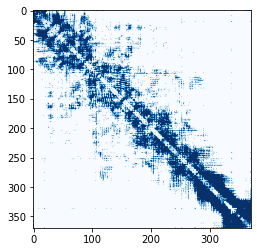

In [55]:
plt.imshow(contact_esm,cmap='Blues')

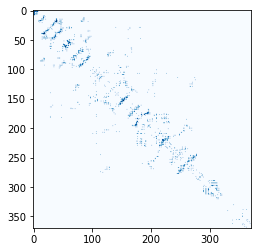

In [58]:
plt.imshow(contact_esm,cmap='Blues')

In [75]:
# Alphafold2

In [ ]:
for uniprot_ID in uniprot_IDs:
    print(f'At entry {counter}/{len(uniprot_IDs)}')
    download = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_ID}-F1-model_v2.pdb'
    file_name = f'../data/alphafold_data/AF_PDBs/AF-{uniprot_ID}-F1-model_v2.pdb'
    #bio.retrieve_pdb_file(pdb,pdir='../data/tmep/', file_format='pbd')
    urllib.request.urlretrieve(download, file_name)
       